<a href="https://colab.research.google.com/github/Dopamine-Max/FFN-Milestone-projects/blob/main/Predicting_Heart_Disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# #2 ANN MILESTONE PROJECT
##Predicting Heart Disease using the UCI Heart Disease Dataset
####Building an FFN that can use the dataset to predict a healthy heart from one that is unhealthy using a processed/smaller version of the University of California Heart Disease Dataset.

#####Data information:
https://archive.ics.uci.edu/ml/datasets/Heart+Disease

#####Data source:
https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data

In [ ]:
# import libraries

#for DL modeling
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,TensorDataset
from sklearn.model_selection import train_test_split

#for number-crunching
import numpy as np
import scipy.stats as stats

#for dataset management
import pandas as pd

#for data visualization
import matplotlib.pyplot as plt
from IPython import display
display.set_matplotlib_formats('svg')

<ipython-input-825-7c74e01ad2c6>:20: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


In [ ]:
# import and process the data

#import the data
url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data'
data = pd.read_csv(url,sep=',',header=None)
data.columns = ['age','sex','cp','trestbps','chol','fbs','restecg','thalach','exang','oldpeak','slope','ca','thal','DISEASE']

#data contain some ?'s; replace with NaN and drop those rows
data = data.replace('?',np.nan).dropna()

print(data)

#z-score all cols except binary ones
cols2zscore = data.keys().drop(['sex','fbs','exang','DISEASE'])

for c in cols2zscore:
  data[c] = pd.to_numeric(data[c]) #forcing to numeric due to some data-formating error

data[cols2zscore] = data[cols2zscore].apply(stats.zscore)

#re-code DISEASE events to 0 (absent) and 1 (present) - previously 0 = no disease & 1,2,3 = severity of disease
data['DISEASE'][data['DISEASE']>0] = 1
data

      age  sex   cp  trestbps   chol  fbs  restecg  thalach  exang  oldpeak  \
0    63.0  1.0  1.0     145.0  233.0  1.0      2.0    150.0    0.0      2.3   
1    67.0  1.0  4.0     160.0  286.0  0.0      2.0    108.0    1.0      1.5   
2    67.0  1.0  4.0     120.0  229.0  0.0      2.0    129.0    1.0      2.6   
3    37.0  1.0  3.0     130.0  250.0  0.0      0.0    187.0    0.0      3.5   
4    41.0  0.0  2.0     130.0  204.0  0.0      2.0    172.0    0.0      1.4   
..    ...  ...  ...       ...    ...  ...      ...      ...    ...      ...   
297  57.0  0.0  4.0     140.0  241.0  0.0      0.0    123.0    1.0      0.2   
298  45.0  1.0  1.0     110.0  264.0  0.0      0.0    132.0    0.0      1.2   
299  68.0  1.0  4.0     144.0  193.0  1.0      0.0    141.0    0.0      3.4   
300  57.0  1.0  4.0     130.0  131.0  0.0      0.0    115.0    1.0      1.2   
301  57.0  0.0  2.0     130.0  236.0  0.0      2.0    174.0    0.0      0.0   

     slope   ca thal  DISEASE  
0      3.0  0.0  6.

<ipython-input-826-da142ca6c0a7>:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['DISEASE'][data['DISEASE']>0] = 1


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,DISEASE
0,0.936181,1.0,-2.240629,0.750380,-0.276443,1.0,1.010199,0.017494,0.0,1.068965,2.264145,-0.721976,0.655877,0
1,1.378929,1.0,0.873880,1.596266,0.744555,0.0,1.010199,-1.816334,1.0,0.381773,0.643781,2.478425,-0.894220,1
2,1.378929,1.0,0.873880,-0.659431,-0.353500,0.0,1.010199,-0.899420,1.0,1.326662,0.643781,1.411625,1.172577,1
3,-1.941680,1.0,-0.164289,-0.095506,0.051047,0.0,-1.003419,1.633010,0.0,2.099753,2.264145,-0.721976,-0.894220,0
4,-1.498933,0.0,-1.202459,-0.095506,-0.835103,0.0,1.010199,0.978071,0.0,0.295874,-0.976583,-0.721976,-0.894220,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.272059,0.0,0.873880,0.468418,-0.122330,0.0,-1.003419,-1.161395,1.0,-0.734914,0.643781,-0.721976,1.172577,1
298,-1.056185,1.0,-2.240629,-1.223355,0.320744,0.0,-1.003419,-0.768432,0.0,0.124076,0.643781,-0.721976,1.172577,1
299,1.489615,1.0,0.873880,0.693988,-1.047008,1.0,-1.003419,-0.375469,0.0,2.013854,0.643781,1.411625,1.172577,1
300,0.272059,1.0,0.873880,-0.095506,-2.241384,0.0,-1.003419,-1.510696,1.0,0.124076,0.643781,0.344824,1.172577,1


In [ ]:
# RE-ORGANIZE the data into train/test loaders

#convert pandas dataframe to tensors
dataT = torch.tensor(data[data.keys().drop('DISEASE')].values).float()
labels = torch.tensor(data['DISEASE'].values).float()
labels = labels[:,None] #labels have to a tensor of 1 column instead of size[297] it should be size[297,1]

#use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(dataT,labels,test_size=0.1)

#convert to Pytorch datasets
train_data = TensorDataset(train_data,train_labels)
test_data = TensorDataset(test_data,test_labels)

#convert to dataloaders
batchsize    = 27
train_loader = DataLoader(train_data,batch_size=batchsize,shuffle=True,drop_last=True)
test_loader  = DataLoader(test_data,batch_size=test_data.tensors[0].shape[0])

In [ ]:
# check sizes of data batches
for X,y in train_loader:
  print(X.shape,  y.shape)

torch.Size([27, 13]) torch.Size([27, 1])
torch.Size([27, 13]) torch.Size([27, 1])
torch.Size([27, 13]) torch.Size([27, 1])
torch.Size([27, 13]) torch.Size([27, 1])
torch.Size([27, 13]) torch.Size([27, 1])
torch.Size([27, 13]) torch.Size([27, 1])
torch.Size([27, 13]) torch.Size([27, 1])
torch.Size([27, 13]) torch.Size([27, 1])
torch.Size([27, 13]) torch.Size([27, 1])


In [ ]:
# function to create the model
def createHeartnet():
  class theNet(nn.Module):
    def __init__(self):
      super().__init__()

      #input layer
      self.input = nn.Linear(13,32)

      #hidden layers
      self.fc1 = nn.Linear(32,16)
      self.fc2 = nn.Linear(16,8)

      #output layer
      self.output = nn.Linear(8,1)

    #forward pass
    def forward(self,x):
      x = F.relu( self.input(x) )
      x = F.relu( self.fc1(x) )
      x = F.relu( self.fc2(x) )
      return self.output(x)

  #declaration as a function
  Heartnet = theNet()

  #loss function
  loss_func = nn.BCEWithLogitsLoss()

  #optimizer
  optimizer = torch.optim.Adam(Heartnet.parameters(), lr=.0001)

  return Heartnet,loss_func,optimizer

In [ ]:
#test the model
net,lossfun,optimizer = createHeartnet()

X,y = next(iter(train_loader))
yHat = net(X)

yHat

tensor([[0.2764],
        [0.2921],
        [0.2948],
        [0.2964],
        [0.2778],
        [0.2765],
        [0.2952],
        [0.2935],
        [0.3090],
        [0.3001],
        [0.2642],
        [0.2732],
        [0.2695],
        [0.2837],
        [0.3064],
        [0.2726],
        [0.2715],
        [0.2656],
        [0.2835],
        [0.2687],
        [0.2767],
        [0.2989],
        [0.2760],
        [0.2916],
        [0.2691],
        [0.3224],
        [0.2532]], grad_fn=<AddmmBackward0>)

In [ ]:
# function that trains the model
def trainHeartnet():

  #declare epochs and create the model
  epochs = 1500
  net,loss_func,optimizer = createHeartnet()

  #intialize losses and accuracies
  losses = torch.zeros(epochs)
  trainAcc = []
  testAcc = []

  #loop over epochs
  for epochi in range(epochs):

    #loop over training batches
    batchAcc = []
    batchLoss = []
    for X,y in train_loader:

      # forward pass and loss
      yHat = net(X)
      loss = loss_func(yHat,y)

      # backprop
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # loss from this batch
      batchLoss.append(loss.item())

      #compute accuracy
      batchAcc.append( 100*torch.mean(((yHat>0)==y).float()))
    #end of batch loop

    #average training accuracy across batches
    trainAcc.append(np.mean(batchAcc))
    #average loss across batches
    losses[epochi] = np.mean(batchLoss)

    #test computation
    X,y = next(iter(test_loader))
    with torch.no_grad():
      yHat = net(X)

    #compute accuracy for test
    testAcc.append( 100*torch.mean(((yHat>0)==y).float()))

  #end of epochs

  return trainAcc,testAcc,losses,net


<function matplotlib.pyplot.show(close=None, block=None)>

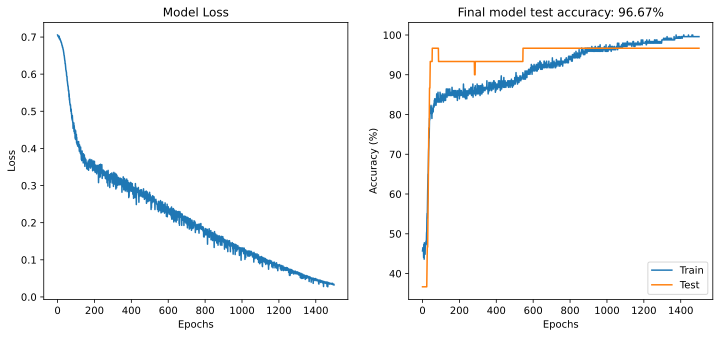

In [ ]:
#Running and plotting results regarding performance

trainAcc,testAcc,losses,net = trainHeartnet()

fig,ax = plt.subplots(1,2,figsize=(12,5))

ax[0].plot(losses)
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss')
ax[0].set_title('Model Loss')

ax[1].plot(trainAcc,label='Train')
ax[1].plot(testAcc,label='Test')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_title(f'Final model test accuracy: {testAcc[-1]:.2f}%')
ax[1].legend()

plt.show